In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


## **IMDB Films Review Sentiment Text Classification using Keras**
The text data, used in this notebook, is the film reviews data from IMDB resource. In this python notebook i would like to create a mechanism for **text classification** into two groups (positive, negative), based on the sentiment.  We are going to accomplish this task by building neural networks using the Keras framework.

## **Import packages**
We start by importing the packages. 

In [30]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import re
from nltk.stem import WordNetLemmatizer

## **Load and inspect data** 
Let's load the data and inspect its structure.


In [31]:
df = pd.read_csv("../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv",
                 sep=',')

In [32]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Let us find the factors for sentiment values and convert them to integer values (0 and 1) for the algorithm to be able to process.

In [33]:
# ----- Get labels -----
y = np.int32(df.sentiment.astype('category').cat.codes.to_numpy())
# ----- Get number of classes -----
num_classes = np.unique(y).shape[0]

In [34]:
print(y)

[1 1 1 ... 0 0 0]


## Preprocess text

Before we apply any algorithm, we need to have a cleaned data set. In our case with text data, it is essential to perform preprocessing steps in order to increase the performance of the algorithms. The steps we perform are: 
* remove br tags
* remove all single characters
* substituting multiple spaces with single space
* removing prefixed 'b'
* converting to lowercase

The final preprocessing step is the lemmatization. In lemmatization, we reduce the word into dictionary root form. For instance "cats" is converted into "cat". Lemmatization is done in order to avoid creating features that are semantically similar but syntactically different. For instance, we don't want two different features named "cats" and "cat", which are semantically similar, therefore we perform lemmatization.

In [35]:
stemmer = WordNetLemmatizer()
def custom_standardization(text):
    
    text = re.sub('<br />', ' ', str(text))
    
    text = re.sub(r'\W', ' ', str(text))
    
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    
    # converting to Lowercase
    text = text.lower()
    
    # lemmatization
    text = text.split()

    text = [stemmer.lemmatize(word) for word in text]
    text = ' '.join(text)
    
    return text
    pass

In [36]:
df['Cleaned_Text'] = df.review.apply(custom_standardization)

In [37]:
df['Cleaned_Text'].head()

0    one of the other reviewer ha mentioned that af...
1    a wonderful little production the filming tech...
2    i thought this wa wonderful way to spend time ...
3    basically there a family where little boy jake...
4    petter mattei love in the time of money is vis...
Name: Cleaned_Text, dtype: object

Further we are going to use a word embedding representation for our text data reviews. A word embedding is a class of approaches for representing words and documents using a dense vector representation, where a vector represents the projection of the word into a continuous vector space. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. The position of a word in the learned vector space is referred to as its embedding. More information about word embeddings can be found here: 
* https://www.tensorflow.org/tutorials/text/word_embeddings

Before we use word embeddings, we need to convert our words into integers first. To do this we define the size of our vocabulary (max_features) and find the most occuring words in our data, to be used in the dictionary. After that, we use a tokenizer to represent each review as an integer vector corresponding to the dictionary.
Tokenizer vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. 

In [38]:
# ----- Prepare text for embedding -----
max_features = 10000

In [39]:
# ----- Get top 10000 most occuring words in list-----
results = Counter()
df['Cleaned_Text'].str.split().apply(results.update)
vocabulary = [key[0] for key in results.most_common(max_features)]

# ----- Create tokenizer based on your top 10000 words -----
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(vocabulary)



In [40]:
df['Cleaned_Text']

0        one of the other reviewer ha mentioned that af...
1        a wonderful little production the filming tech...
2        i thought this wa wonderful way to spend time ...
3        basically there a family where little boy jake...
4        petter mattei love in the time of money is vis...
                               ...                        
49995    i thought this movie did down right good job i...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    i am catholic taught in parochial elementary s...
49998    i going to have to disagree with the previous ...
49999    no one expects the star trek movie to be high ...
Name: Cleaned_Text, Length: 50000, dtype: object

In [41]:

# ----- Convert words to ints and pad -----
X = tokenizer.texts_to_sequences(df['Cleaned_Text'].values)
X = pad_sequences(X)


# ----- Split into Train, Test, Validation sets -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## **Define and train a model**

To crete an embedding layer in Keras we need to give as input 3 parameters. 
* input_dim: This is the size of the vocabulary in the text data
* output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger
* input_length: This is the length of input sequences, as you would define for any input layer of a Keras model

In [42]:
output_dim = 16
max_input_lenght = X.shape[1]

We define a sequential keras model, starting with an embedding layer with output dimension 16. After that we use GlobalAveragePooling1D layer and one Dense layer. 
A GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units. Finally, the dense layer with two classes is used for classification.

In [43]:
# ----- Define model -----
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_features, output_dim=output_dim, input_length=max_input_lenght))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# ----- Compile model -----
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["accuracy"])




In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2113, 16)          160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2113, 16)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 160,306
Trainable params: 160,306
Non-trainable params: 0
_________________________________________________________________


In [45]:
# ----- Train model -----
history_1 = model.fit(X_train, y_train, batch_size=8,epochs=20, validation_data=(X_val, y_val))



Epoch 1/20
4000/4000 [==============================] - 22s 5ms/step - loss: 0.6919 - accuracy: 0.5445 - val_loss: 0.6898 - val_accuracy: 0.5349
Epoch 2/20
4000/4000 [==============================] - 24s 6ms/step - loss: 0.6837 - accuracy: 0.6617 - val_loss: 0.6752 - val_accuracy: 0.7339
Epoch 3/20
4000/4000 [==============================] - 22s 6ms/step - loss: 0.6584 - accuracy: 0.7449 - val_loss: 0.6389 - val_accuracy: 0.7577
Epoch 4/20
4000/4000 [==============================] - 22s 5ms/step - loss: 0.6106 - accuracy: 0.7862 - val_loss: 0.5818 - val_accuracy: 0.8101
Epoch 5/20
4000/4000 [==============================] - 22s 5ms/step - loss: 0.5500 - accuracy: 0.8114 - val_loss: 0.5207 - val_accuracy: 0.8284
Epoch 6/20
4000/4000 [==============================] - 22s 5ms/step - loss: 0.4916 - accuracy: 0.8281 - val_loss: 0.4663 - val_accuracy: 0.8410
Epoch 7/20
4000/4000 [==============================] - 22s 5ms/step - loss: 0.4414 - accuracy: 0.8430 - val_loss: 0.4230 - val_ac

## **Evaluate the model**

In [49]:
# ----- Evaluate model -----
probabilities = model.predict(X_test)
pred = np.argmax(probabilities, axis=1)

print(" ")
print("Results")

accuracy = accuracy_score(y_test, pred)

print('Accuracy: {:.4f}'.format(accuracy))
print(" ")
print(classification_report(y_test, pred))

 
Results
Accuracy: 0.8952
 
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [50]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

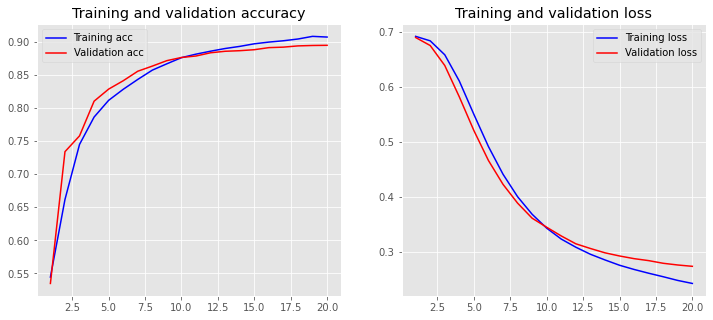

In [51]:
plot_history(history_1)

We obtained quite good results of 89% accuracy on a test data set with a simple NN design. With the plots above we also see that we are not doing too much overfitting.

As a next step the parameters of the neural network can be optimized by performing a grid search. 